<a href="https://colab.research.google.com/github/leekj3133/dss_JU/blob/main/Dacon/Lv2.%20%EA%B2%B0%EC%B8%A1%EC%B9%98%20%EB%B3%B4%EA%B0%84%EB%B2%95%EA%B3%BC%20%EB%9E%9C%EB%8D%A4%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8%EB%A1%9C%20%EB%94%B0%EB%A6%89%EC%9D%B4%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EC%98%88%EC%B8%A1%ED%95%98%EA%B8%B0/Lv2_%ED%8A%9C%EB%8B%9D_3_5_Grid_Search%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [↩️ 리스트로 돌아가기](https://dacon.io/competitions/open/235698/overview/description)

# 셀을 실행할 때 팝업이 뜨면 `무시하고 계속하기` 를 눌러주세요


## 데이터 다운로드
--- 
아래 셀을 실행시켜 데이터를 colab에 불러옵니다.  
셀 실행은 Ctrl + Enter 를 이용해 실행 시킬 수 있습니다. 

In [1]:
# 데이터 다운로드 링크로 데이터를 코랩에 불러옵니다.

!wget 'https://bit.ly/3gLj0Q6'

import zipfile
with zipfile.ZipFile('3gLj0Q6', 'r') as existing_zip:
    existing_zip.extractall('data')

--2021-09-08 08:46:27--  https://bit.ly/3gLj0Q6
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/uc?export=download&id=1or_QN1ksv81DNog6Tu_kWcZ5jJWf5W9E [following]
--2021-09-08 08:46:27--  https://drive.google.com/uc?export=download&id=1or_QN1ksv81DNog6Tu_kWcZ5jJWf5W9E
Resolving drive.google.com (drive.google.com)... 142.250.136.138, 142.250.136.100, 142.250.136.139, ...
Connecting to drive.google.com (drive.google.com)|142.250.136.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9u4bv23el6gv0fl6fv2mq8hre2gd2prs/1631090775000/17946651057176172524/*/1or_QN1ksv81DNog6Tu_kWcZ5jJWf5W9E?e=download [following]
--2021-09-08 08:46:28--  https://doc-0c-10-docs.googleusercontent.com/docs/secur

## 라이브러리 불러오기
---
아래 셀을 실행시켜 pandas 와 DecisionTreeClassifier 를 불러옵니다.

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

## 데이터 불러오기
---
아래 셀을 실행시켜 csv 파일 데이터를 DataFrame 객체로 불러옵니다.

In [3]:
train = pd.read_csv('data/train.csv') 
test = pd.read_csv('data/test.csv')

## 전처리
---
train 은 interpolate() 를 이용해 결측치를 DataFrame 값에 선형으로 비례하여 보간합니다.
test 의 결측치는 0으로 채워줍니다.

In [4]:
train.interpolate(inplace=True)
test.fillna(0, inplace=True)

In [5]:
# 앞 과정에서 파악된 변수 중요도가 낮은 피쳐드를 제거합니다.

X_train = train.drop(['count', 'id', 'hour_bef_windspeed', 'hour_bef_pm2.5'], axis=1)
Y_train = train['count']
test = test.drop(['id', 'hour_bef_windspeed', 'hour_bef_pm2.5'], axis=1)

하이퍼파라미터 튜닝:  정지규칙 값들을 설정하는 것

의사결정나무의 정지규칙(stopping criteria) 

1. 최대깊이 (max_depth) : 최대로 내려갈 수 있는 depth
 - 뿌리 노드로부터 내려갈 수 있는 깊이 지정, 작을수록 트리 작아짐
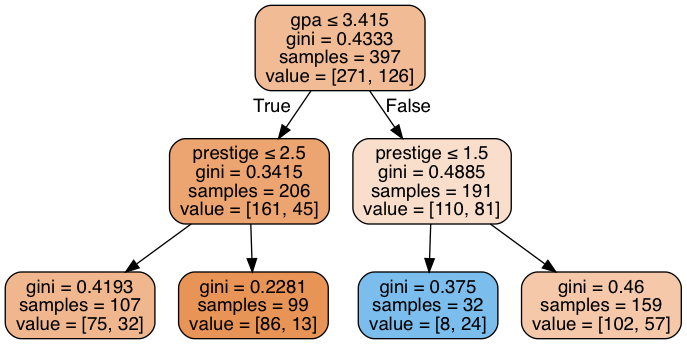

2. 최소 노드크기(min_samples_split) : 노드를 분할하기 위한 데이터 수
- 해당 노드에 이 값보다 적은 확률변수 수가 있다면 stop. 
- 작을수록 트리 커짐

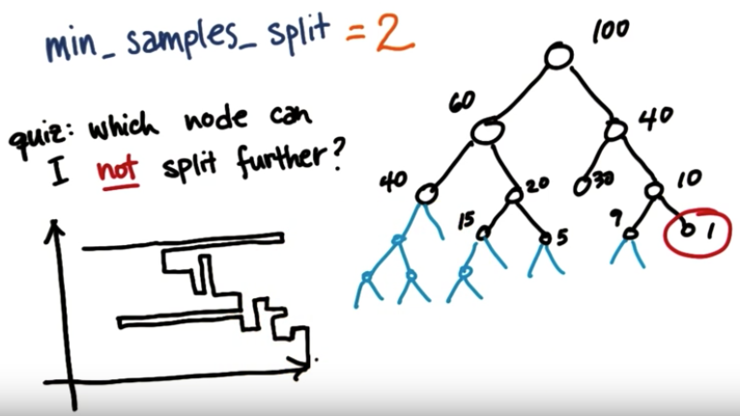

3. 최소 향상도(min_impurity_decrease) 
- 노드를 분할하기 위한 최소 향상도
- 향상도가 설정값 이하라면 더 이상 분할하지 않음
- 작을수록 트리는 커짐

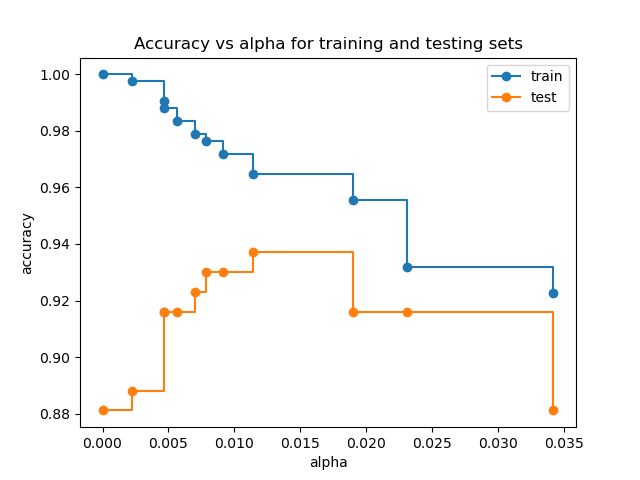

4. 비용복잡도(Cost-complexity) 
- 트리가 커지는 것에 대해 패널티 계수를 설정해서 불순도와 트리가 커지는 것에 대해 복잡도 계산
- 비용복잡도(Cost-complexity)함수
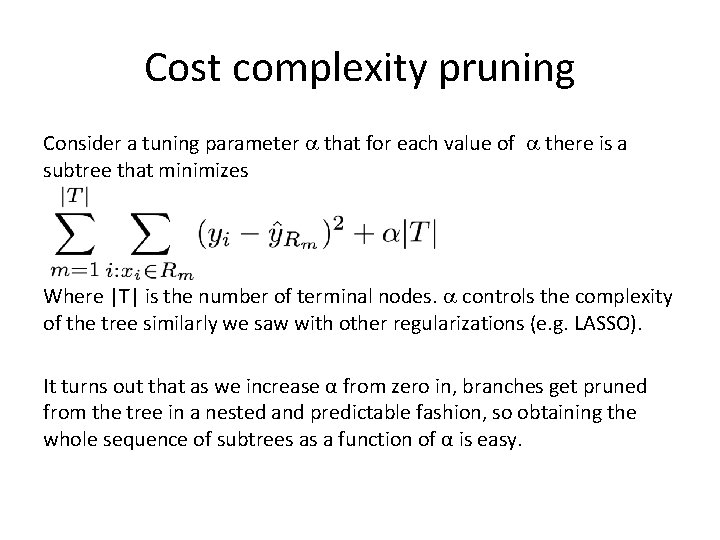
  - |T|: 최종노드의 개수
  - 𝛼: 패널티 계수 (트리가 커지는 것에 대한 패널티를 사용자가 정함)
    - 각 𝛼 값마다, 가장 Cost 를 적게 하는 트리 T 가 존재함
  - 𝛼=0 이라면, 최대크기의 트리가 가장 선호됨 (0.5 면 뿌리노드)

 - 𝛼 값이 작으면 train 데이터에 대해서는 정확도가 높음
 -  test 데이터에 대해서는 정확도가 낮을수밖에 없음
 - 모든 𝛼 값을 비교해보면 최적의 𝛼 값을 관찰 가능
 
=> 이러한 최적의 𝛼 값은 교차타당성(Cross-Validation) 을 통해 찾을 수 있음.

</br>

이와 같은 정지규칙들을 종합적으로 고려해 최적의 조건값을 설정
=> 이를 하이퍼파라미터 튜닝이라고 합니다.



하이퍼파라미터 튜닝에 방법론(다양함)
Best 성능을 나타내는 GridSearch : 완전 탐색(Exhaustive Search)사용 => 가능한 모든 조합 중에서 가장 우수한 조합 찾아줌
=> 하지만, 완전 탐색이기 때문에 Best 조합을 찾을 때까지 시간이 매우 오래 걸림(단점)

https://github.com/pyohamen/Im-Being-Data-Scientist/wiki/Hyperparameters-tuning

GridSearchCV 모듈로 완전탐색 하이퍼파라미터 튜닝을 구현해보겠습니다.


```
from sklearn.model_selection import GridSearchCV


model = RandomForestRegressor(criterion = 'mse', random_state=2020)


params = {'n_estimators': [200, 300, 500],
          'max_features': [5, 6, 8],
          'min_samples_leaf': [1, 3, 5]}


greedy_CV = GridSearchCV(model, param_grid=params, cv = 3, n_jobs = -1)
greedy_CV.fit(X_train, Y_train)
```

## 👋 실습
---

In [7]:
from sklearn.model_selection import GridSearchCV
 
 
model = RandomForestRegressor(criterion = 'mse', random_state=2020)
 
 
params = {'n_estimators': [200, 300, 500],
          'max_features': [5, 6, 8],
          'min_samples_leaf': [1, 3, 5]}
 
 
greedy_CV = GridSearchCV(model, param_grid=params, cv = 3, n_jobs = -1)
greedy_CV.fit(X_train, Y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=2020,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [13]:
pred = greedy_CV.predict(test)
pred

array([105.54333333, 214.12      ,  84.47      ,  40.77      ,
        59.20333333, 123.42333333, 194.43333333, 317.70666667,
        42.04      , 111.56333333, 295.17666667, 250.64      ,
        88.01666667,  41.04      , 208.23333333, 142.61      ,
        26.64      , 171.33333333, 344.54      , 153.84      ,
       232.16      ,  85.77333333,  25.5       , 140.47333333,
       142.61      , 114.72      ,  29.69666667, 116.35666667,
       112.89666667, 148.77      ,  75.32      ,  34.78333333,
        71.21      , 130.01      , 267.44333333,  40.01666667,
       129.84333333, 103.61666667, 244.90333333,  91.13      ,
        58.15      , 122.29      , 152.97      ,  91.05333333,
       333.61333333, 216.60333333,  94.61333333,  66.12666667,
        18.46666667,  85.43      , 226.15666667,  91.92666667,
       178.04      ,  82.18333333, 187.81666667, 131.50333333,
        51.48      , 171.97666667,  22.02      ,  20.24333333,
        88.26      ,  88.27      , 255.10333333, 307.49

In [14]:
submission = pd.read_csv('data/submission.csv')

In [18]:
import numpy as np

submission['count'] = np.round(pred,2)
submission.head()

,id,count
0,0,105.54
1,1,214.12
2,2,84.47
3,4,40.77
4,5,59.20


In [19]:
submission.to_csv('sub.csv',index=False)

## 정답
---

In [ ]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor(criterion = 'mse', random_state=2020)

params = {'n_estimators': [200, 300, 500],
          'max_features': [5, 6, 8],
          'min_samples_leaf': [1, 3, 5]}

greedy_CV = GridSearchCV(model, param_grid=params, cv = 3, n_jobs = -1)
greedy_CV.fit(X_train, Y_train)

In [ ]:
pred = greedy_CV.predict(test)

In [ ]:
pred

In [ ]:
submission = pd.read_csv('data/submission.csv')

In [ ]:
import numpy as np

submission['count'] = np.round(pred, 2)

In [ ]:
submission.head()

In [ ]:
submission.to_csv('sub.csv',index=False)

# [↩️ 리스트로 돌아가기](https://dacon.io/competitions/open/235698/overview/description)